In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json
from pathlib import Path

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.plot import plot_summary_stats
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

from time import perf_counter

Initialize test slab and parameters

In [3]:
# Initialize paths
surface_name = "SrTiO3(001)"
run_folder = Path() / surface_name
run_folder.mkdir(parents=True, exist_ok=True)

# Load prepared pristine slab
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

system_settings = {
    "surface_name": surface_name,
    "surface_depth": 1,
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.5,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "total_sweeps": 10,
    "sweep_size": 5,
    "start_temp": 1.0,  # in terms of kbT
    "perform_annealing": False,
    "alpha": 1.0,  # no annealing
    "adsorbates": list(calc_settings["chem_pots"].keys()),
    "run_folder": run_folder,
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.82 ]), array([ 1.968,  1.951, 18.779]), array([ 1.968,  0.146, 18.732]), array([ 7.871,  3.956, 18.82 ]), array([ 1.968,  5.936, 18.779])]...


Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

/home/dux/NeuralForceField/models
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [6]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    ads_positions,  # TODO: move ads_positions to be created within SurfaceSystem
    calc=nff_surf_calc,
    system_settings=system_settings,
    default_io_path=run_folder,
)
surface.all_atoms.write(run_folder / "SrTiO3_001_2x2_all_virtual_ads.cif")

2024-06-28 16:45:45,378|INFO|initializing 64 virtual atoms
2024-06-28 16:45:45,382|INFO|Initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-28 16:45:45,383|INFO|Number of pristine atoms is 60
2024-06-28 16:45:45,388|INFO|bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
2024-06-28 16:45:45,389|INFO|surface indices are [ 7  8 22 23 37 38 52 53]
2024-06-28 16:45:45,390|INFO|constraints are FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 59])


      Step     Time          Energy         fmax
BFGS:    0 16:45:46     -467.521881        0.2044
BFGS:    1 16:45:46     -467.525757        0.1803
BFGS:    2 16:45:46     -467.540619        0.0793
BFGS:    3 16:45:46     -467.540924        0.0598
BFGS:    4 16:45:46     -467.541351        0.0059


Test calculate pristine surface

In [7]:
print(f"Surface energy {float(surface.get_surface_energy()):.3f} eV")

Surface energy 12.471 eV


Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

In [8]:
mcmc = MCMC(
    **sampling_settings,
    relax=calc_settings["relax_atoms"],
)

start = perf_counter()
results = mcmc.mcmc_run(
    surface=surface,
    **sampling_settings,
)
stop = perf_counter()
print(f"Time taken = {stop - start:.3f} seconds")

2024-06-28 16:45:47,433|INFO|Running with num_sweeps = 10, sweep_size = 5, start_temp = 1.000
2024-06-28 16:45:47,434|INFO|There are 60 atoms in pristine slab


      Step     Time          Energy         fmax
BFGS:    0 16:45:47     -467.521881        0.2044
BFGS:    1 16:45:47     -467.525757        0.1803
BFGS:    2 16:45:47     -467.540619        0.0793
BFGS:    3 16:45:48     -467.540924        0.0598
BFGS:    4 16:45:48     -467.541351        0.0059


2024-06-28 16:45:48,256|INFO|Initial energy is 12.471
2024-06-28 16:45:48,257|INFO|Using user specified run folder SrTiO3(001)
2024-06-28 16:45:48,258|INFO|Starting with iteration 0
2024-06-28 16:45:48,259|INFO|Temperature schedule is: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000']
2024-06-28 16:45:48,259|INFO|In sweep 1 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:45:48     -470.650391        8.3203
BFGS:    1 16:45:48     -471.693939        5.7267
BFGS:    2 16:45:48     -472.726562        2.9446
BFGS:    3 16:45:48     -473.581940        2.7303
BFGS:    4 16:45:48     -474.031586        2.5582
BFGS:    5 16:45:49     -474.229858        2.2702
BFGS:    6 16:45:49     -474.636566        1.0708
BFGS:    7 16:45:49     -474.928589        1.7130
BFGS:    8 16:45:49     -475.291016        2.9811
BFGS:    9 16:45:49     -475.718842        2.9243
BFGS:   10 16:45:49     -476.132599        1.9061
BFGS:   11 16:45:50     -476.445312        1.2270
BFGS:   12 16:45:50     -476.505035        1.4676
BFGS:   13 16:45:50     -476.637177        1.1297
BFGS:   14 16:45:50     -476.847412        1.0271
BFGS:   15 16:45:50     -476.871613        1.0131
BFGS:   16 16:45:50     -477.008942        0.8783
BFGS:   17 16:45:51     -477.041229        0.8577
BFGS:   18 16:45:51     -477.145966        1.2022
B

2024-06-28 16:46:01,887|INFO|optim structure has Energy = 11.513
2024-06-28 16:46:01,892|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:46:02     -458.237640       42.9260
BFGS:    1 16:46:02     -468.266449       17.3712
BFGS:    2 16:46:02     -471.444244        9.1658
BFGS:    3 16:46:02     -473.538910        5.0377
BFGS:    4 16:46:02     -474.787323        2.5531
BFGS:    5 16:46:02     -475.309845        3.5087
BFGS:    6 16:46:02     -475.594086        2.2679
BFGS:    7 16:46:02     -476.016113        2.0698
BFGS:    8 16:46:02     -476.296021        1.8963
BFGS:    9 16:46:02     -476.603851        1.8989
BFGS:   10 16:46:03     -476.757812        2.1667
BFGS:   11 16:46:03     -477.051910        2.8100
BFGS:   12 16:46:03     -477.471283        2.7763
BFGS:   13 16:46:03     -477.891693        2.5963
BFGS:   14 16:46:03     -478.258820        2.9774
BFGS:   15 16:46:03     -478.758453        3.4067
BFGS:   16 16:46:03     -479.273041        3.6688
BFGS:   17 16:46:03     -479.754639        3.7860
BFGS:   18 16:46:03     -480.442963        3.8939
B

2024-06-28 16:46:12,922|INFO|optim structure has Energy = 6.076
2024-06-28 16:46:12,930|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:46:13     -466.217773       44.3221
BFGS:    1 16:46:13     -480.224274       21.2551
BFGS:    2 16:46:13     -485.492157       10.8118
BFGS:    3 16:46:13     -488.946655        5.8129
BFGS:    4 16:46:13     -490.967743        3.3341
BFGS:    5 16:46:13     -492.105438        2.6202
BFGS:    6 16:46:13     -492.718018        2.3770
BFGS:    7 16:46:13     -493.275269        3.2332
BFGS:    8 16:46:13     -493.924469        4.0113
BFGS:    9 16:46:13     -494.563568        2.6923
BFGS:   10 16:46:14     -495.190704        1.6181
BFGS:   11 16:46:14     -495.511322        1.4970
BFGS:   12 16:46:14     -495.801849        1.8137
BFGS:   13 16:46:14     -496.266357        1.5692
BFGS:   14 16:46:14     -496.561859        1.5211
BFGS:   15 16:46:14     -496.876953        1.2902
BFGS:   16 16:46:14     -497.285004        1.5408
BFGS:   17 16:46:14     -497.448120        1.7215
BFGS:   18 16:46:14     -497.695526        1.8566
B

2024-06-28 16:46:23,776|INFO|optim structure has Energy = 6.076
2024-06-28 16:46:23,785|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:46:23     -424.965912       79.2271
BFGS:    1 16:46:23     -467.117340       50.2435
BFGS:    2 16:46:24     -478.195435       24.3383
BFGS:    3 16:46:24     -486.449341       11.4858
BFGS:    4 16:46:24     -490.614410        7.4545
BFGS:    5 16:46:24     -493.032715        4.5161
BFGS:    6 16:46:24     -494.638214        3.3653
BFGS:    7 16:46:24     -496.031769        3.3270
BFGS:    8 16:46:24     -497.234222        3.0391
BFGS:    9 16:46:24     -498.312256        4.0761
BFGS:   10 16:46:24     -499.403778        4.5564
BFGS:   11 16:46:25     -500.605835        5.4466
BFGS:   12 16:46:25     -502.096222        6.1109
BFGS:   13 16:46:25     -503.748749        5.6121
BFGS:   14 16:46:25     -505.272552        4.9543
BFGS:   15 16:46:25     -506.560883        3.0812
BFGS:   16 16:46:25     -507.663177        2.4326
BFGS:   17 16:46:25     -508.656097        2.6737
BFGS:   18 16:46:25     -509.282990        1.4257
B

2024-06-28 16:46:35,178|INFO|optim structure has Energy = -1.701
2024-06-28 16:46:35,186|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:46:35     -451.245209       43.4620
BFGS:    1 16:46:35     -479.879395       20.6086
BFGS:    2 16:46:35     -491.888763       11.7968
BFGS:    3 16:46:35     -500.563324        7.5406
BFGS:    4 16:46:35     -505.193939        5.5619
BFGS:    5 16:46:35     -508.152496        4.3446
BFGS:    6 16:46:35     -510.050903        3.5333
BFGS:    7 16:46:36     -511.272308        4.7063
BFGS:    8 16:46:36     -512.509583        4.2415
BFGS:    9 16:46:36     -513.676697        2.8254
BFGS:   10 16:46:36     -514.715454        3.0997
BFGS:   11 16:46:36     -515.819092        3.1628
BFGS:   12 16:46:36     -516.688538        2.5156
BFGS:   13 16:46:36     -517.452209        2.3130
BFGS:   14 16:46:36     -518.131531        2.1282
BFGS:   15 16:46:36     -518.844177        2.1068
BFGS:   16 16:46:36     -519.248413        1.9097
BFGS:   17 16:46:37     -519.756531        1.8967
BFGS:   18 16:46:37     -519.988831        1.7500
B

2024-06-28 16:46:46,108|INFO|optim structure has Energy = -2.172
2024-06-28 16:46:46,116|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:46:46     -434.989990       52.1996
BFGS:    1 16:46:46     -467.829468       25.2463
BFGS:    2 16:46:46     -484.789673       15.0841
BFGS:    3 16:46:46     -497.514557        7.5587
BFGS:    4 16:46:46     -503.643951        4.3507
BFGS:    5 16:46:46     -506.971893        6.3902
BFGS:    6 16:46:46     -509.671509        3.5758
BFGS:    7 16:46:46     -511.756927        3.3477
BFGS:    8 16:46:46     -513.466003        2.8287
BFGS:    9 16:46:47     -515.014099        2.6984
BFGS:   10 16:46:47     -516.332214        2.7407
BFGS:   11 16:46:47     -517.528503        2.8307
BFGS:   12 16:46:47     -518.581970        2.6083
BFGS:   13 16:46:47     -520.121521        3.0377
BFGS:   14 16:46:47     -521.226379        2.9957
BFGS:   15 16:46:47     -522.149109        3.0160
BFGS:   16 16:46:47     -522.726807        2.1890
BFGS:   17 16:46:47     -523.158020        2.0968
BFGS:   18 16:46:47     -523.615417        1.6109
B

2024-06-28 16:46:56,603|INFO|optim structure has Energy = -2.172
2024-06-28 16:46:56,609|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:46:56       98.200905     9114.2412
BFGS:    1 16:46:56     -407.626465      272.2995
BFGS:    2 16:46:56     -440.026520      292.2969
BFGS:    3 16:46:57     -455.897308      312.3361
BFGS:    4 16:46:57     -470.688324      303.9601
BFGS:    5 16:46:57     -480.261230      281.6810
BFGS:    6 16:46:57     -488.671021      192.4402
BFGS:    7 16:46:57     -494.448700      114.3766
BFGS:    8 16:46:57     -497.974640       39.9867
BFGS:    9 16:46:57     -498.966766       40.5082
BFGS:   10 16:46:57     -500.397308       37.2488
BFGS:   11 16:46:57     -501.757568       33.9709
BFGS:   12 16:46:57     -503.062286       22.0238
BFGS:   13 16:46:57     -503.918976        6.4901
BFGS:   14 16:46:58     -504.754181        7.9998
BFGS:   15 16:46:58     -506.046753       20.0950
BFGS:   16 16:46:58     -506.771576       14.4599
BFGS:   17 16:46:58     -507.440796        3.3140
BFGS:   18 16:46:58     -508.393646        2.5523
B

2024-06-28 16:47:07,281|INFO|optim structure has Energy = -2.172
2024-06-28 16:47:07,287|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:47:07     -196.036240     4008.8763
BFGS:    1 16:47:07     -411.785614      172.7573
BFGS:    2 16:47:07     -442.684479      151.7889
BFGS:    3 16:47:07     -456.629150      155.0509
BFGS:    4 16:47:07     -470.213379      163.4448
BFGS:    5 16:47:07     -482.570160      192.3603
BFGS:    6 16:47:07     -492.970947      167.6965
BFGS:    7 16:47:08     -498.236115       79.1607
BFGS:    8 16:47:08     -500.827148       19.4583
BFGS:    9 16:47:08     -502.897949       19.1716
BFGS:   10 16:47:08     -505.398682       10.2654
BFGS:   11 16:47:08     -506.293304        6.1381
BFGS:   12 16:47:08     -507.884186        5.1876
BFGS:   13 16:47:08     -509.003784       11.3598
BFGS:   14 16:47:08     -509.799774       10.2595
BFGS:   15 16:47:08     -510.438080       33.3146
BFGS:   16 16:47:08     -511.717041        5.6264
BFGS:   17 16:47:08     -512.926819        4.7698
BFGS:   18 16:47:09     -514.104797        5.9889
B

2024-06-28 16:47:17,870|INFO|optim structure has Energy = -2.172
2024-06-28 16:47:17,875|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:47:17     -401.440216      114.9827
BFGS:    1 16:47:18     -438.771881       62.5840
BFGS:    2 16:47:18     -458.109222       34.2763
BFGS:    3 16:47:18     -447.216339      504.9872
BFGS:    4 16:47:18     -474.453644      233.3091
BFGS:    5 16:47:18     -488.539551       24.6309
BFGS:    6 16:47:18     -495.747894       11.9485
BFGS:    7 16:47:18     -502.233368       14.6539
BFGS:    8 16:47:18     -506.653778        7.7628
BFGS:    9 16:47:18     -509.689850        3.9089
BFGS:   10 16:47:18     -511.353058        5.8006
BFGS:   11 16:47:19     -512.865967        3.8665
BFGS:   12 16:47:19     -514.466736       13.6560
BFGS:   13 16:47:19     -515.446960        9.0256
BFGS:   14 16:47:19     -516.469849        4.5240
BFGS:   15 16:47:19     -517.071228        1.8604
BFGS:   16 16:47:19     -517.324524        2.6538
BFGS:   17 16:47:19     -517.525330        2.9624
BFGS:   18 16:47:19     -517.702637        3.8707
B

2024-06-28 16:47:28,655|INFO|optim structure has Energy = -2.172
2024-06-28 16:47:28,664|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 16:47:28    34330.558594   815352.0025
BFGS:    1 16:47:28     -300.669647     2133.5800
BFGS:    2 16:47:28     -417.332611      419.1063
BFGS:    3 16:47:29     -441.530853      414.9679
BFGS:    4 16:47:29     -466.041626      149.6600
BFGS:    5 16:47:29     -476.802582      112.4165
BFGS:    6 16:47:29     -478.233643      227.5194
BFGS:    7 16:47:29     -488.869781       36.0454
BFGS:    8 16:47:29     -490.358795      176.6690
BFGS:    9 16:47:29     -496.101349      143.2536
BFGS:   10 16:47:29     -501.070679       93.7549
BFGS:   11 16:47:29     -504.925934       49.9588
BFGS:   12 16:47:29     -507.192474       27.3217
BFGS:   13 16:47:29     -508.015900       31.7054
BFGS:   14 16:47:30     -509.683258       21.2608
BFGS:   15 16:47:30     -510.217560       11.5861
BFGS:   16 16:47:30     -510.903412       11.4648
BFGS:   17 16:47:30     -512.150696        3.0062
BFGS:   18 16:47:30     -512.925781        9.6788
B

2024-06-28 16:47:40,706|INFO|optim structure has Energy = -2.172


Time taken = 113.280 seconds


Plot results

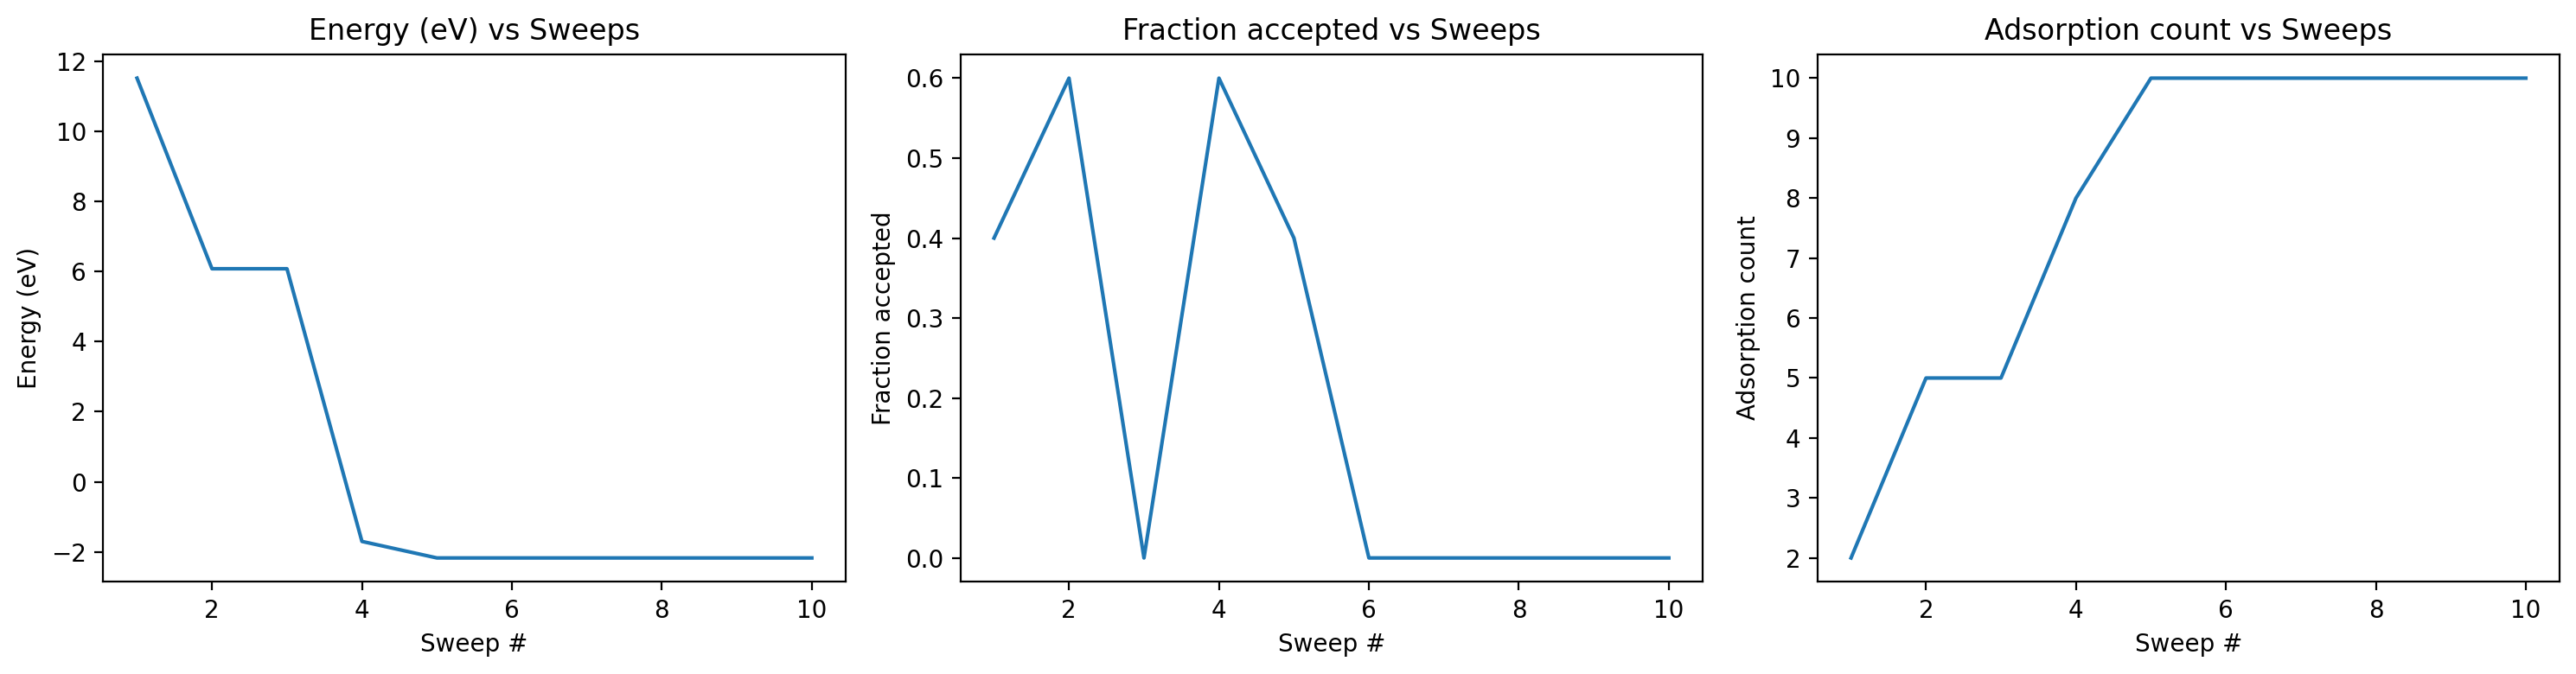

In [9]:
fig = plot_summary_stats(
    results["energy_hist"],
    results["frac_accept_hist"],
    results["adsorption_count_hist"],
    sampling_settings["total_sweeps"],
    save_folder=run_folder,
)

Save structures for later use in latent space clustering or analysis

In [10]:
structures = results["history"]
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)